### Importing Libraries

In [2]:
#import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import warnings

warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 55)

### Import Data

In [4]:
# main folder
path = r'C:\Users\steve\Documents\Olist Marketplace Analysis'

# data
df = pd.read_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'project_data_w_flags.pkl'))

### Analysis

#### 1. Prep Data

create subset with only needed columns for analysis : **time purchased** and **time delivered**

In [8]:
df.head(1)

,order_id,seller_id,customer_id,product_id,product_category,price,freight_value,order_total,order_purchased_time,order_delivered_time,order_estimated_delivery_date,purchase_to_approved_hrs,delivery_time_hrs,product_description_length,product_photos_qty,review_score,customer_state,seller_state,num_orders,return_customer,num_orders_w_seller,return_to_seller,num_items,delivery_difference,on_time_flag,num_orders_received,total_revenue,unq_products_sold,revenue_flag,frequency_flag
0,b81ef226f3fe1789b1e8b2acac839d17,213b25e6f54661939f11710a6fddb871,0a8556ac6be836b46b3e89920d59291c,af74cc53dcffc8384b29e7abfa41902b,home_construction,79.8,19.53,99.33,2018-04-25 22:01:49,2018-05-09 17:36:51,2018-05-22,0.22,331.58,921.0,8.0,1.0,MG,SP,1,0,1,0,1,-13.0,early,200,15989.0,81,Low revenue,New customer


In [9]:
df_time = df[['order_purchased_time', 'order_delivered_time']]

In [10]:
df_time.head(3)

,order_purchased_time,order_delivered_time
0,2018-04-25 22:01:49,2018-05-09 17:36:51
1,2018-06-26 11:01:38,2018-06-29 20:32:09
2,2017-12-12 11:19:55,2017-12-18 17:24:41


In [11]:
df_time['order_purchased_time'].dtype, df_time['order_delivered_time'].dtype

(dtype('O'), dtype('<M8[ns]'))

Since columns are of type object, convert them to datetime so the date can be extracted.

In [13]:
# convert timestamp cols to datetime
df_time['order_purchased_time'] = pd.to_datetime(df_time['order_purchased_time'])
df_time['order_delivered_time'] = pd.to_datetime(df_time['order_delivered_time'])

In [14]:
# extract date and time from timestamp col (order_purchase_timestamp)
df_time['order_date'] = df_time['order_purchased_time'].dt.to_period('M')
df_time['order_hour'] = df_time['order_purchased_time'].dt.hour

In [15]:
df_time.head(3)

,order_purchased_time,order_delivered_time,order_date,order_hour
0,2018-04-25 22:01:49,2018-05-09 17:36:51,2018-04,22
1,2018-06-26 11:01:38,2018-06-29 20:32:09,2018-06,11
2,2017-12-12 11:19:55,2017-12-18 17:24:41,2017-12,11


**Create list of orders placed per month.**

In [17]:
# create a df that stores the number of orders per month - year
df_s1 = df_time.groupby('order_date').size().reset_index(name='num_orders')

# convert orer_date back to timestamp (sets it as first of month) - so can plot data
df_s1['order_date'] = df_s1['order_date'].dt.to_timestamp()

# set the order_date col as the index
df_s1.set_index('order_date', inplace=True)

df_s1

,num_orders
order_date,
2016-09-01,3
2016-10-01,385
2016-12-01,1
2017-01-01,1023
2017-02-01,2073
2017-03-01,3201
2017-04-01,2864
2017-05-01,4445
2017-06-01,3822


**Missing:** data is missing for 2016 - 11, need to add it in with a 0 for num_orders

In [19]:
# create a complete range of months (from earliest to latest month in the data)
start_date = df_s1.index.min()
end_date = df_s1.index.max()
full_range = pd.date_range(start=start_date, end=end_date, freq='MS') # set frequency to 1st of month

# reindex df_s1 to the above full range of months, filling in 0 for any missing
df_s1 = df_s1.reindex(full_range, fill_value=0)

df_s1.head()

,num_orders
2016-09-01,3
2016-10-01,385
2016-11-01,0
2016-12-01,1
2017-01-01,1023


**Remove:** Remove the last month since their is only 1 order which appears to be an error as the previous months had 7,000 - 8,000.

In [21]:
# remove last month : 2018-09-01
#df_s1.drop('2016-09-01', inplace=True)
#df_s1.drop('2016-10-01', inplace=True)
#df_s1.drop('2016-11-01', inplace=True)
#df_s1.drop('2016-12-01', inplace=True)
df_s1.drop('2018-09-01', inplace=True)

df_s1

,num_orders
2016-09-01,3
2016-10-01,385
2016-11-01,0
2016-12-01,1
2017-01-01,1023
2017-02-01,2073
2017-03-01,3201
2017-04-01,2864
2017-05-01,4445
2017-06-01,3822


#### 2. Visualize Data

Text(0, 0.5, 'Number of Orders')

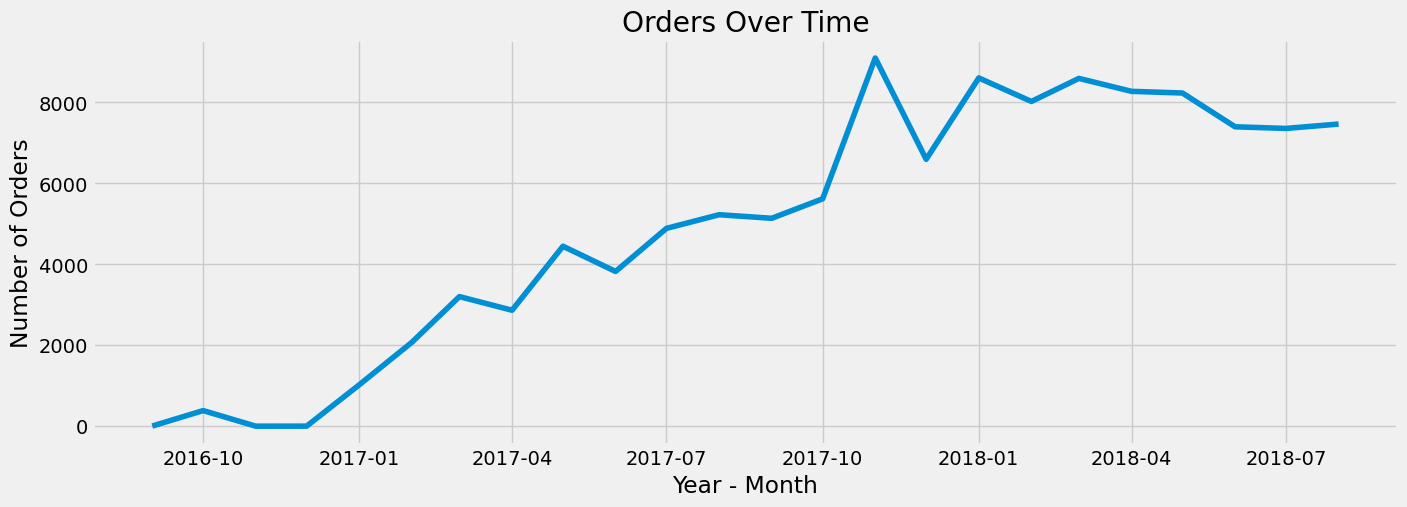

In [23]:
# plot data
plt.figure(figsize=(15,5), dpi = 100)
orders_plt = plt.plot(df_s1)
plt.title('Orders Over Time')
plt.xlabel('Year - Month')
plt.ylabel('Number of Orders')

**Insight:** Sales are increasing over time at Olist.

#### 3. Time-series analysis: decomposition

*Identify patterns, trends, and seasonality over time*

In [27]:
# decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(df_s1, model='additive')

In [28]:
from pylab import rcParams
# define a fixed size for all special charts
rcParams['figure.figsize'] = 18, 7 

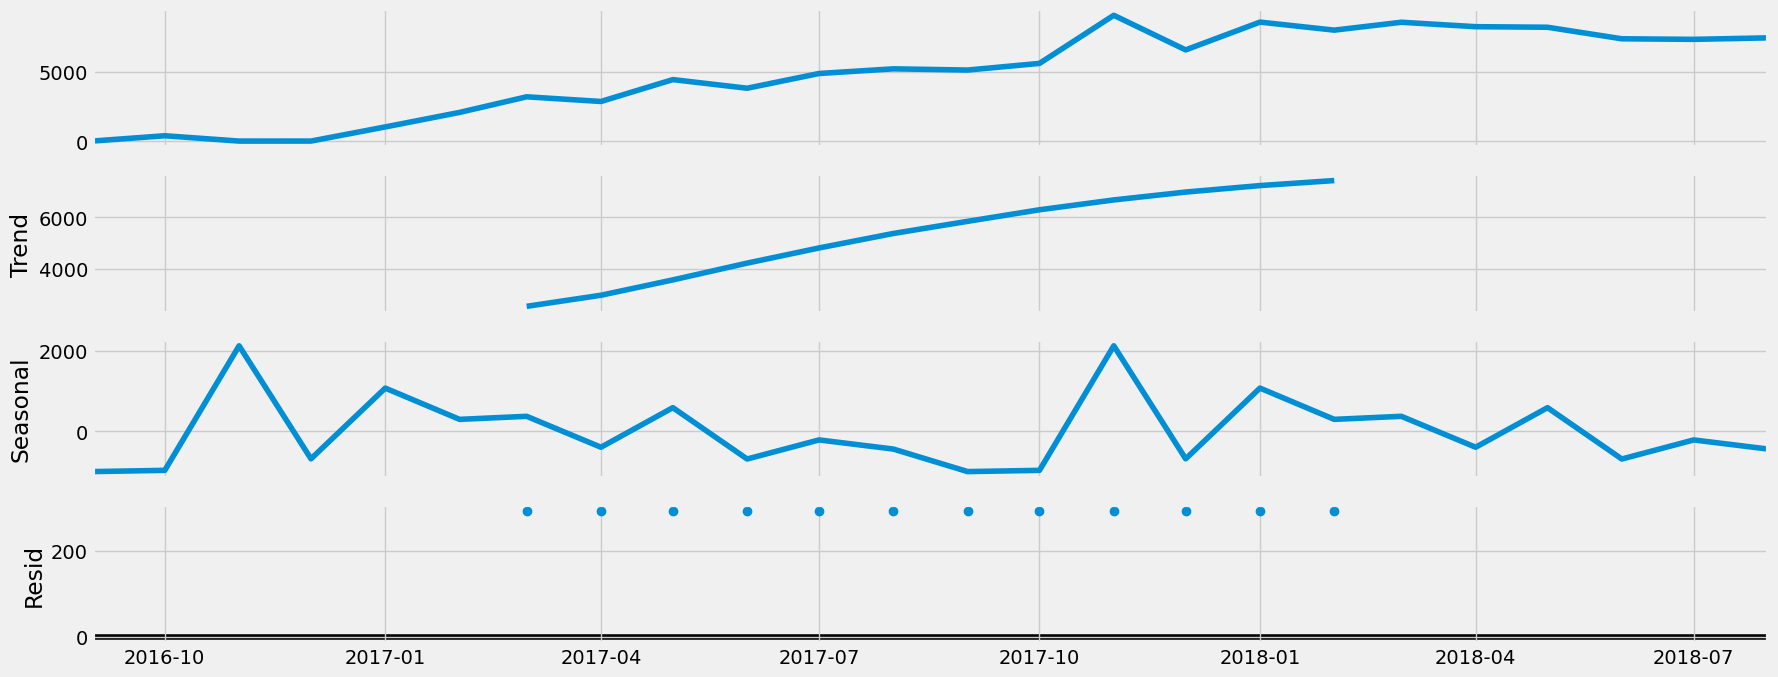

In [29]:
# plot decomposition components
decomposition.plot()
plt.show()

**Insights:**
- **Trend:** There is an upward trend indicated by the long-term upward movement of the line.
- **Seasonal:** There is a seasonality to the data as it repeats itself periodically at the same time each year. There is a spike in November followed by a decline in December. There are mini spikes in Jan, Mar, and May and a relatively even decline during late Summer to early Fall.
- **Noise/Residual:** There is no obvious noise seen by the horizontal residual line.

#### 3. Testing for stationary

In [32]:
# perform the Dickey-Fuller test to look for a unit root (any jump in the data that's not constant)
# null hypothesis = the prescence of a unit root.
from statsmodels.tsa.stattools import adfuller 

def dickey_fuller(timeseries):
    print('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic', 'p-value', 'Number of Lags Used', 'Number of Observations Used'])
    for key,value in test[4].items():
        result['Critical Value (%s)'%key] = value
    print(result)

dickey_fuller(df_s1['num_orders'])

Dickey-Fuller Stationarity test:
Test Statistic                 -1.502299
p-value                         0.532374
Number of Lags Used             1.000000
Number of Observations Used    22.000000
Critical Value (1%)            -3.769733
Critical Value (5%)            -3.005426
Critical Value (10%)           -2.642501
dtype: float64


**Insights:** The Critical Value (5%) is -3.01 which is a lot smaller than the test statistic (-1.50), which means the null hypothesis - that there is a unit root in the data- cannot be rejected. Therefore the data is non-stationary.

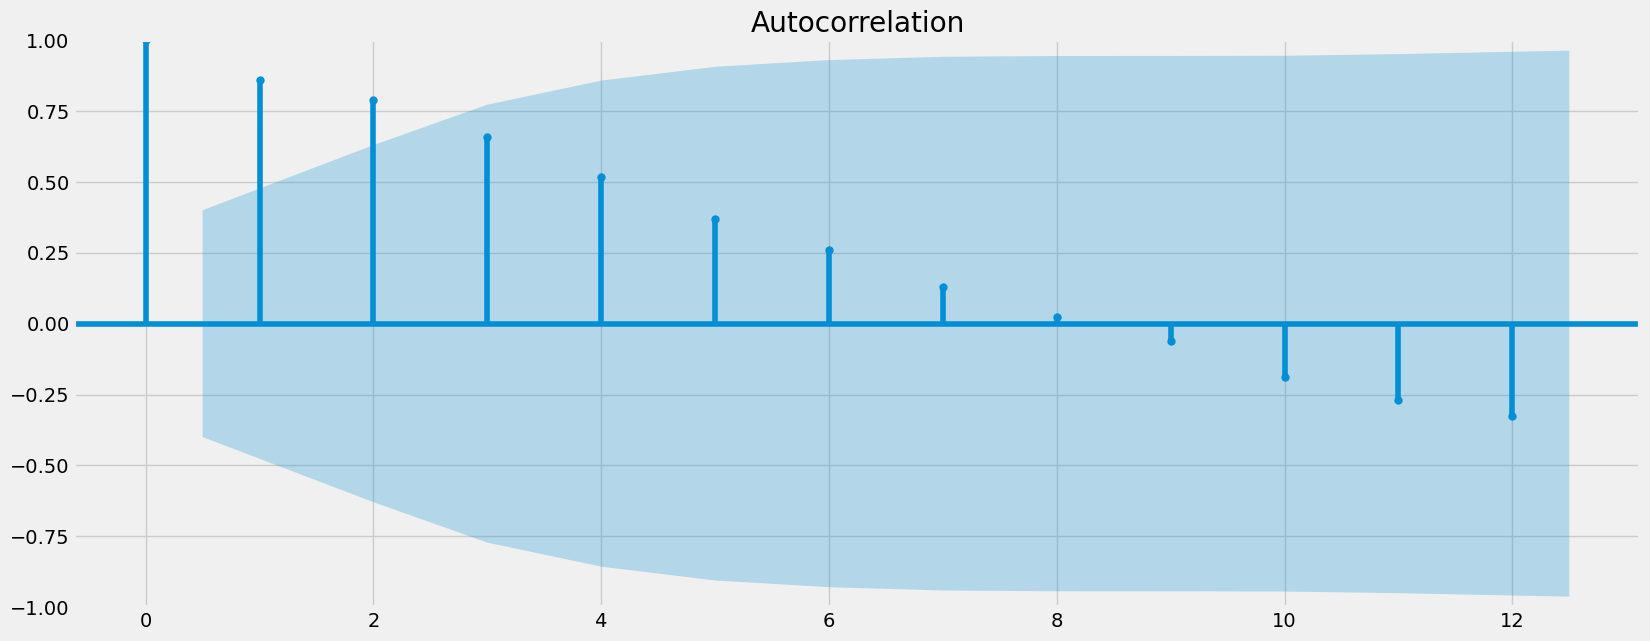

In [34]:
# plot autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_s1)
plt.show()

The vertical lines represent the lags in the series, while the blue area represents the confidence interval. When lines go above the blue edge of the confidence interval, this means you have lags that are significantly correlated with each other. 

In this data, there are only 3 lines outside of the blue indicating that there is not alot of autocorrelated data.

#### 4. Stationarizing the Data

In [37]:
data_diff = df_s1 - df_s1.shift(1) # t - (t-1)

In [38]:
# remove missing values that come as a result of the differencing
data_diff.dropna(inplace = True)

In [39]:
data_diff.head()

,num_orders
2016-10-01,382.0
2016-11-01,-385.0
2016-12-01,1.0
2017-01-01,1022.0
2017-02-01,1050.0


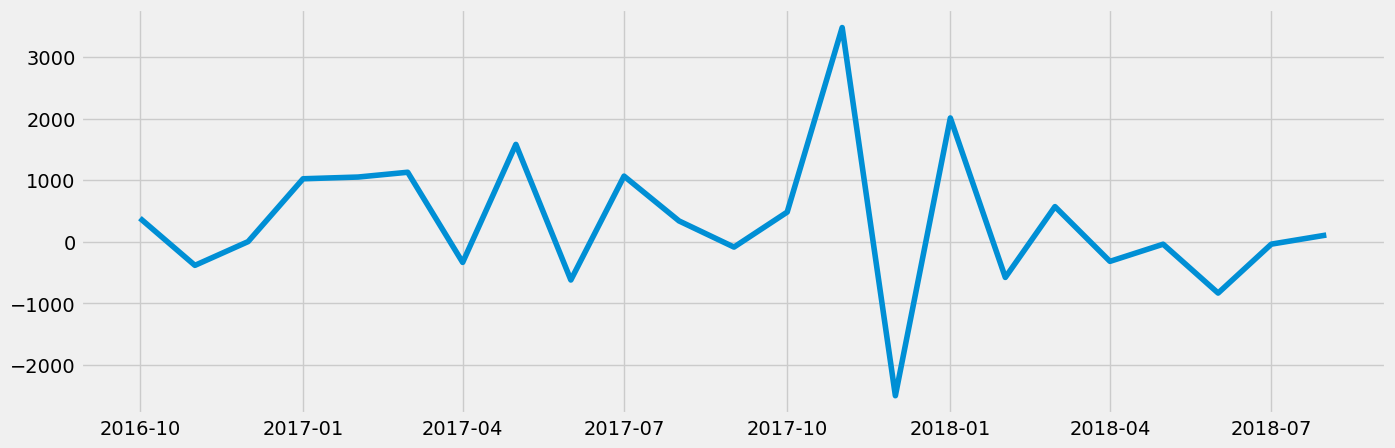

In [40]:
# plot time series curve
plt.figure(figsize=(15,5), dpi =100)
plt.plot(data_diff)

Plot is not more flattened - removed the upward trend over time.

In [42]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -8.254899e+00
p-value                        5.269326e-13
Number of Lags Used            0.000000e+00
Number of Observations Used    2.200000e+01
Critical Value (1%)           -3.769733e+00
Critical Value (5%)           -3.005426e+00
Critical Value (10%)          -2.642501e+00
dtype: float64


**Note:** The 5% Critical Value (~ -3) is now larger than the Test Statistic (~ -8), which means the null hypothesis can be rejected and the series can be considered stationary, and therefore primed for forecasting.

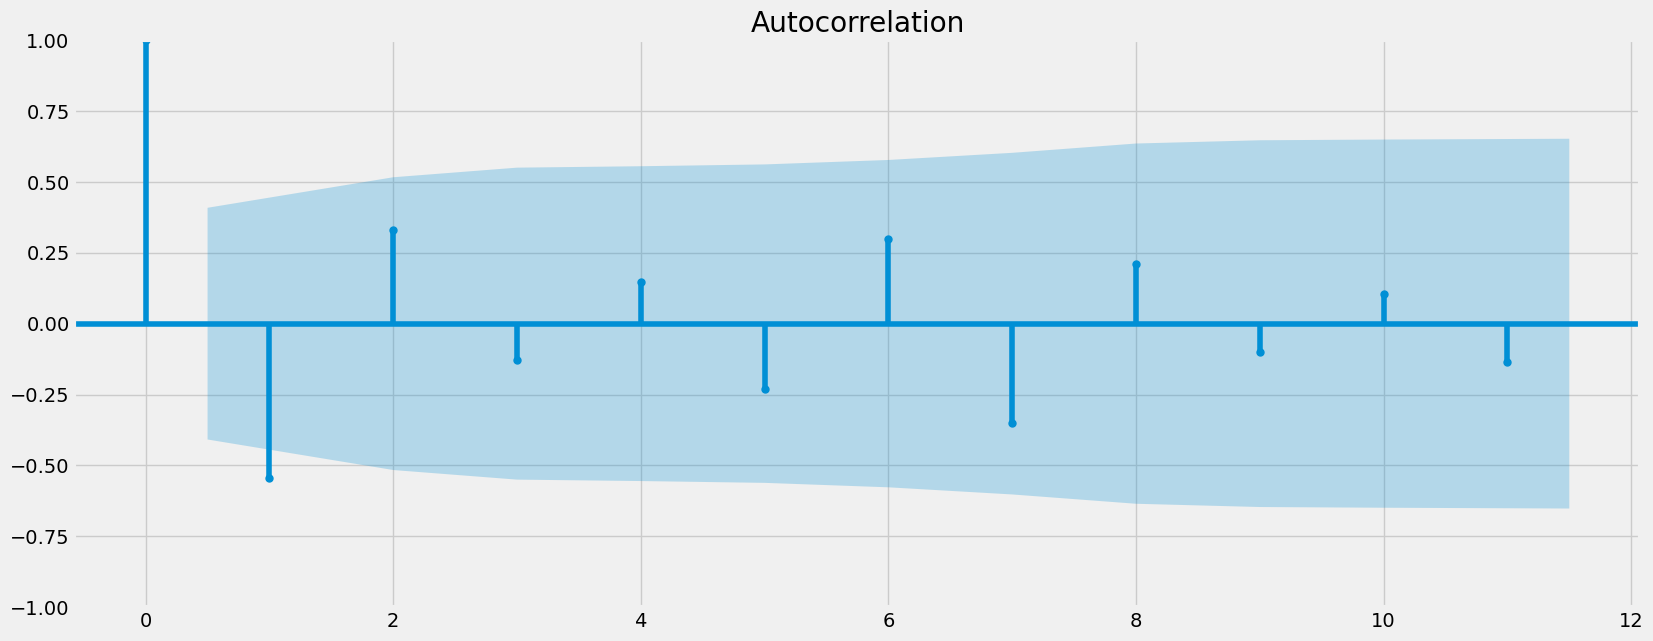

In [44]:
plot_acf(data_diff)
plt.show()

**Note:** Now only 2 lines remains outside of the blue, this line could be a result of the spike in month 2 at a little under 400 where surrounding months 1, 3, and 4 are at 0 - 3 orders.

With their being only 1 line outside of the blue, the stationarity of the data is not weak.

### Export Data

In [47]:
df.to_csv(os.path.join(path, '02 Data', 'Prepared Data', 'project_data_last-MM-removed.csv'))